# Monopod on Skateboard
### Model a monopod to apply backfoot applied force on the skateboard

In [109]:
# import libraries
import pickle as pkl
import sympy as sym
import numpy as np

sym.init_printing()
from IPython.display import display #for pretty printing

# DERIVE EOMS OF BOARD --------------------------------------------------------------------------------------------------------

# system parameters
g = sym.symbols('g')
mb = sym.symbols('m_{board}') # mass
lb = sym.symbols('l_{board}') # length
lbr = sym.symbols('l_{wheels}') # length to reaction forces
hb = sym.symbols('h_{board}') # height - board clearance
Inb = sym.symbols('In_{board}') # moment of intertia
rF_FF, rF_BF = sym.symbols(['r_{F_{FF}}','r_{F_{BF}}']) # distance of feet from COM. 

# generalized coordinates
x,y,thb = sym.symbols(['x','y','\\theta_{board}']) 
dx,dy,dthb = sym.symbols(['\dot{x}','\dot{y}','\dot{\\theta}_{board}']) 
ddx,ddy,ddthb = sym.symbols(['\ddot{x}','\ddot{y}','\ddot{\\theta}_{board}']) 

q = sym.Matrix([[x],[y],[thb]])
dq = sym.Matrix([[dx],[dy],[dthb]])
ddq = sym.Matrix([[ddx],[ddy],[ddthb]])

# forces
GRF_BW,GRF_FW = sym.symbols(['GRF_{BW}','GRF_{FW}']) # ground reaction forces
F_BFx,F_BFy = sym.symbols(['F_{BFx}','F_{BFy}']) # back foot applied forces
F_FFx,F_FFy = sym.symbols(['F_{FFx}','F_{FFy}']) # front foot applied forces

# Unpickle stored EOMs
infile = open('skateboard_EOMs','rb')
data = pkl.load(infile)
infile.close()

EOMs_board = data['EOMs']

In [110]:
# Lambdify EOMs
from pyomo.environ import*
from pyomo.opt import SolverFactory
from pyomo.opt import SolverStatus, TerminationCondition

func_map = {'sin':sin, 'cos':cos} 

sym_list = [g,mb,lb,lbr,Inb,hb,
            x,y,thb,
            dx,dy,dthb,
            ddx,ddy,ddthb,
            rF_BF,rF_FF,
            F_BFx,F_BFy,F_FFx,F_FFy,
            GRF_BW,GRF_FW]
            
lambEOMx_board   = sym.lambdify(sym_list,EOMs_board[0],modules = [func_map])
lambEOMy_board   = sym.lambdify(sym_list,EOMs_board[1],modules = [func_map])
lambEOMth_board  = sym.lambdify(sym_list,EOMs_board[2],modules = [func_map])

In [111]:
# DERIVE EOMS OF MONOPOD --------------------------------------------------------------------------------------------------------

from IPython.display import display #for pretty printing

# create symbolic variables

# system parameters
g = sym.symbols('g')
mb,ml1,ml2 = sym.symbols(['m_{body}','m_{leg1}','m_{leg2}']) # mass
lb,ll1,ll2 = sym.symbols(['l_{body}','l_{leg1}','l_{leg2}']) # length
Inb,Inl1,Inl2 = sym.symbols(['I_{body}','I_{leg1}','I_{leg2}']) # moment of intertia

# generalized coordinates
x,y,thb,thl,r = sym.symbols(['x','y','\\theta_{body}','\\theta_{leg}','r']) 
dx,dy,dthb,dthl,dr = sym.symbols(['\dot{x}','\dot{y}','\dot{\\theta}_{body}','\dot{\\theta}_{leg}','\dot{r}']) 
ddx,ddy,ddthb,ddthl,ddr = sym.symbols(['\ddot{x}','\ddot{y}','\ddot{\\theta}_{body}','\ddot{\\theta}_{leg}','\ddot{r}']) 

q = sym.Matrix([[x],[y],[thb],[thl],[r]])
dq = sym.Matrix([[dx],[dy],[dthb],[dthl],[dr]])
ddq = sym.Matrix([[ddx],[ddy],[ddthb],[ddthl],[ddr]])

# forces
# total joint action = actuator + rebound, but that will be dealt with elsewhere
F,tau,GRFx,GRFy = sym.symbols(['F','\\tau','G_x','G_y']) 

# Unpickle stored EOMs
infile = open('monopod_EOMs','rb')
data = pkl.load(infile)
infile.close()

EOMs_monopod = data['EOMs']

In [112]:
# Lambdify
from pyomo.environ import*
from pyomo.opt import SolverFactory
from pyomo.opt import SolverStatus, TerminationCondition

func_map = {'sin':sin, 'cos':cos} 

sym_list = [g,mb,ml1,ml2,lb,ll1,ll2,Inb,Inl1,Inl2,
            x,y,thb,thl,r,
            dx,dy,dthb,dthl,dr,
            ddx,ddy,ddthb,ddthl,ddr,
            F,tau,GRFx,GRFy]
            
lambEOMxb_monopod = sym.lambdify(sym_list,EOMs_monopod[0],modules = [func_map])
lambEOMyb_monopod = sym.lambdify(sym_list,EOMs_monopod[1],modules = [func_map])
lambEOMthb_monopod = sym.lambdify(sym_list,EOMs_monopod[2],modules = [func_map])
lambEOMthl_monopod = sym.lambdify(sym_list,EOMs_monopod[3],modules = [func_map])
lambEOMr_monopod = sym.lambdify(sym_list,EOMs_monopod[4],modules = [func_map])

In [113]:
if 'm' in globals():
    del m # deletes the model
    
m = ConcreteModel()

# SETS-----------------------------------------------------------------------------------------------------------------------

N = 25
m.N = RangeSet(N)

DOFs = ['x','y','th','xb','yb','thb','thl','r'] # generalized coordinates
m.DOF = Set(initialize = DOFs) 

Fs = ['BFx','BFy','FFx','FFy'] # front foot, backfoot
m.Fs = Set(initialize = Fs) 

rFs = ['BF','FF'] # front foot, backfoot
m.rFs = Set(initialize = rFs) 

GRFs = ['BW','FW'] # front wheel, back wheel
m.GRFs = Set(initialize = GRFs) 

links = [('body',1),('leg',1),('leg',2)]
m.L = Set(dimen=2, initialize = links)

WDOFs = ['X','Y','THETA'] # absolute coordinates
m.WDOF = Set(initialize = WDOFs)

# PARAMETERS-----------------------------------------------------------------------------------------------------------------

# general
m.g = Param(initialize = 9.81) # gravity

# board
m.mbd = Param(initialize = 2.0) # mass of board
m.lbd = Param(initialize = 0.80) # length of board
m.lbrd = Param(initialize = 0.45) # length between wheels lb-(14.3+3)*2
m.hbd = Param(initialize = 0.09) # board clearance
#m.etail = Param(initialize = -0.6) #coefficient of restitution of tail
m.Inbd = Param(initialize = 1/12*m.mbd*m.lbd**2) # moment of inertia about centre

BW_sb = m.mbd*m.g

# monopod
def get_m(n, lb, ln):
    if lb == 'body':
        return 5.0
    else: return 2.5
m.m = Param(m.L, initialize = get_m) # mass of links

def get_len(n, lb, ln):
    if lb == 'body':
        return 1.0
    else: return 0.5
m.len = Param(m.L, initialize = get_len) # length of links

def calculate_In(m, lb, ln): 
    l = (lb,ln)
    return 1/12*m.m[l]*m.len[l]**2 
m.In = Param(m.L, initialize = calculate_In) # moment of inertia

m_monopod = sum(m.m[l] for l in links)
BW = m_monopod*m.g

# VARIABLES -----------------------------------------------------------------------------------------------------------------

# system coordinates
m.q = Var(m.N, m.DOF) # position
m.dq = Var(m.N, m.DOF) # velocity
m.ddq = Var(m.N, m.DOF) # acceleration

# applied and ground reaction forces and torques
# sign set for positive and negative components
signs = ['ps','ng'] 
m.sgn = Set(initialize = signs)

m.F = Var(m.N, m.Fs, bounds = (0.0, None)) # Force from front foot > 0
m.GRF = Var(m.N, m.GRFs, bounds = (0.0, None)) # Ground reaction force on back wheel
m.tau_a = Var(m.N, bounds = (-2,2)) # actuator torque at hip
m.F_a = Var(m.N, bounds = (-3,3)) # actuator force at knee
m.F_r = Var(m.N, m.sgn, bounds = (0.0,None)) # rebound force (acts parallel to the leg)

# AUXILIARY VARIABLES

# skateboard
m.ptail = Var(m.N, m.DOF) # back of board
m.pnose = Var(m.N, m.DOF) # front of board
m.pbackwheel = Var(m.N, m.DOF) # position of backwheel
m.pfrontwheel = Var(m.N, m.DOF) # position of frontwheel
m.vtail = Var(m.N, m.DOF) # velocity of back of board

def def_ptail(m,n,dof):
    if dof == 'x':
        return m.ptail[n, 'x'] == m.q[n,'x'] - 0.5*m.lbd*cos(m.q[n,'th'])
    if dof == 'y':
        return m.ptail[n, 'y'] == m.q[n,'y'] - 0.5*m.lbd*sin(m.q[n,'th']) 
    else:
        return Constraint.Skip
m.def_ptail = Constraint(m.N, m.DOF,rule = def_ptail)

def def_pnose(m,n,dof):
    if dof == 'x':
        return m.pnose[n, 'x'] == m.q[n,'x'] + 0.5*m.lbd*cos(m.q[n,'th'])
    if dof == 'y':
        return m.pnose[n, 'y'] == m.q[n,'y'] + 0.5*m.lbd*sin(m.q[n,'th']) 
    else:
        return Constraint.Skip
m.def_pnose = Constraint(m.N, m.DOF,rule = def_pnose)

def def_pbackwheel(m,n,dof):
    if dof == 'x':
        return m.pbackwheel[n, 'x'] == m.q[n,'x']-0.5*m.lbrd*cos(m.q[n,'th'])+m.hbd*sin(m.q[n,'th'])
    if dof == 'y':
        return m.pbackwheel[n, 'y'] == m.q[n,'y']-0.5*m.lbrd*sin(m.q[n,'th'])-m.hbd*cos(m.q[n,'th'])
    else:
        return Constraint.Skip
m.def_pbackwheel = Constraint(m.N, m.DOF,rule = def_pbackwheel)

def def_pfrontwheel(m,n,dof):
    if dof == 'x':
        return m.pfrontwheel[n, 'x'] == m.q[n,'x']+0.5*m.lbrd*cos(m.q[n,'th'])+m.hbd*sin(m.q[n,'th'])
    if dof == 'y':
        return m.pfrontwheel[n, 'y'] == m.q[n,'y']+0.5*m.lbrd*sin(m.q[n,'th'])-m.hbd*cos(m.q[n,'th'])
    else:
        return Constraint.Skip
m.def_pfrontwheel = Constraint(m.N, m.DOF,rule = def_pfrontwheel)

def def_vtail(m,n,dof):
    if dof == 'y':
        return m.vtail[n, 'y'] == m.dq[n,'y']-m.dq[n,'th']*0.5*m.lbd*cos(m.q[n,'th'])
    else:
        return Constraint.Skip
m.def_vtail = Constraint(m.N, m.DOF,rule = def_vtail)

# bound variables
for n in range(1,N+1):
    m.pnose[n,'y'].setlb(0.0)
    m.ptail[n,'y'].setlb(0.0)
    m.pbackwheel[n,'y'].setlb(0.0)
    m.pfrontwheel[n,'y'].setlb(0.0)
    m.q[n,'th'].setub(np.pi/2)
    m.q[n,'th'].setlb(-np.pi/2)

for n in range(1,N+1):  
    m.q[n,'thb'].setlb(-np.pi/2)
    m.q[n,'thb'].setub(np.pi/2)
    m.q[n,'thl'].setlb(-np.pi/2)
    m.q[n,'thl'].setub(np.pi/2)

# monopod 
m.pfoot = Var(m.N, m.WDOF) # foot position

def def_pfoot(m,n,dof):
    L = 0.5*m.len[('leg',1)] + m.q[n,'r'] + 0.5*m.len[('leg',2)] # total leg length
    thA = m.q[n,'thb'] + m.q[n,'thl'] # absolute leg angle
    if dof == 'Y':    
        return m.pfoot[n,dof] == m.q[n,'yb'] - L*cos(thA)
    if dof == 'X':
        return m.pfoot[n,dof] == m.q[n,'xb'] + L*sin(thA)
    else:
        return Constraint.Skip
m.def_pfoot = Constraint(m.N, m.WDOF, rule = def_pfoot)

# TIME AND INTEGRATION --------------------------------------------------------------------------------------------------------

# variable timestep
hm  = 0.02 #master timestep
m.h = Var(m.N, bounds = (0.8,1.2))

# Integration constraints 
def BwEuler_p(m,n,dof): # for positions
    if n > 1:
        return m.q[n,dof] == m.q[n-1,dof] + hm*m.h[n]*m.dq[n,dof]
    else:
        return Constraint.Skip 
m.integrate_p = Constraint(m.N, m.DOF, rule = BwEuler_p)

def BwEuler_v(m,n,dof): # for velocities
    if n > 1:
        return m.dq[n,dof] == m.dq[n-1,dof] + hm*m.h[n]*m.ddq[n-1,dof]
    else:
        return Constraint.Skip 
m.integrate_v = Constraint(m.N, m.DOF, rule = BwEuler_v)

In [114]:
# Constraints for foot and board contact --------------------------------------------------------------------------------------

m.rF = Var(m.N, m.rFs, bounds = (0.5*m.lbrd, 0.5*m.lbd)) # distance to applied force
m.qc = Var(m.N, m.WDOF) # point of contact between ball and board
m.d = Var(m.N, bounds = (0.0, None))

def def_qc(m,n,dof): # contact point on board
    if dof == 'X':
        return m.qc[n,'X'] == m.pfoot[n,'X'] + m.d[n]*sin(m.q[n,'th'])
    if dof == 'Y':
        return m.qc[n,'Y'] == m.pfoot[n,'Y'] - m.d[n]*cos(m.q[n,'th'])
    else:
        return Constraint.Skip
m.def_qc = Constraint(m.N, m.WDOF, rule = def_qc)

def def_rF(m,n): # contact point on board
    return m.rF[n,'BF'] == m.q[n,'x']-m.pfoot[n,'X'] #*1/cos(m.q[n,'thb'])
m.def_rF = Constraint(m.N, rule = def_rF)

def ineq_pfoot(m,n,dof): # constraint on position of foot
    if dof == 'X':
        return m.pfoot[n,'X'] <= m.qc[n,'X']
    if dof == 'Y':
        return m.pfoot[n,'Y'] >= m.qc[n,'Y']
    else:
        return Constraint.Skip
m.ineq_pfoot = Constraint(m.N, m.WDOF, rule = ineq_pfoot)

    
def def_d(m,n):
    return m.d[n] == m.pfoot[n,'Y'] - m.ptail[n,'y']
#     return m.d[n] == m.q[n,'y_ball'] - m.qc[n,'y']
m.def_d = Constraint(m.N, rule = def_d)

In [115]:
# -----------------------------------------------------------------------------------------------------------------------------
# Contact Forces
# -----------------------------------------------------------------------------------------------------------------------------

ground_constraints = ['contact_BW','contact_FW']
m.ground_constraints = Set(initialize = ground_constraints) # set for indexing ground-related penalties
m.ground_penalty = Var(m.N, m.ground_constraints, bounds = (0.0,None))

contact_constraints = ['contact_Fy','contact_Fx']
m.contact_constraints = Set(initialize = contact_constraints) # set for indexing ground-related penalties
m.contact_penalty = Var(m.N, m.contact_constraints, bounds = (0.0,None))

# ground contact complemetarity  
def ground_contact(m,n,gc):
    if n < N:
        if gc == 'contact_FW':
            return m.ground_penalty[n,'contact_FW'] == m.pfrontwheel[n+1,'y']*m.GRF[n,'FW'] 
        if gc == 'contact_BW':
            return m.ground_penalty[n,'contact_BW'] == m.pbackwheel[n+1,'y']*m.GRF[n,'BW']
        else:
            return Constraint.Skip
    else:
        return Constraint.Skip
m.ground_contact = Constraint(m.N, m.ground_constraints, rule = ground_contact)

# foot on board contact complemetarity  
def foot_board_contact(m,n,cc):
    if n < N:
        if cc == 'contact_Fx':
            return m.contact_penalty[n,'contact_Fx'] == m.d[n+1]*m.F[n,'BFx']
        if cc == 'contact_Fy':
            return m.contact_penalty[n,'contact_Fy'] == m.d[n+1]*m.F[n,'BFy']
        else:
            return Constraint.Skip
    else:
        return Constraint.Skip
m.foot_board_contact = Constraint(m.N, m.contact_constraints, rule = foot_board_contact)

for grf in GRFs:
    m.GRF[N, grf].fix(0.0)
    
for fs in Fs:
    m.F[N, fs].fix(0.0)
    
for gnd in ground_constraints:
    m.ground_penalty[N, gnd].fix(0.0)

for cc in contact_constraints:
    m.contact_penalty[N, cc].fix(0.0)
    


In [116]:
# Reaction force at knee

# sets
joints = ['hip','knee']
m.J = Set(initialize = joints)

joint_constraints = ['up','lo'] # set of joint penalties
m.joint_constraints = Set(initialize = joint_constraints)

knee_bound = [0.0,0.5]
m.knee_bound = Param(m.joint_constraints, initialize = {'up':knee_bound[1],'lo':knee_bound[0]})

# we can bound the joint coordinates directly
for n in range(1,N+1):
    m.q[n,'r'].setlb(knee_bound[0])
    m.q[n,'r'].setub(knee_bound[1])
    
m.joint_penalty = Var(m.N, m.J, m.joint_constraints, bounds = (0.0,None))

def knee_limits(m,n,jc):
    if n < N:
        if jc == 'up':
            # NEXT distance
            return m.joint_penalty[n,'knee',jc] == (m.knee_bound['up'] - m.q[n+1,'r'])*m.F_r[n,'ng']
        else:
            return m.joint_penalty[n,'knee',jc] == (m.q[n+1,'r'] - m.knee_bound['lo'])*m.F_r[n,'ps']
    else:
        return Constraint.Skip
m.knee_limits = Constraint(m.N, m.joint_constraints, rule = knee_limits)

# bound contact forces at last node
for sgn in signs:
    m.F_r[N,sgn].value = 0
    m.F_r[N,sgn].fixed = True

In [117]:
# -----------------------------------------------------------------------------------------------------------------------------
# EOMs 
# -----------------------------------------------------------------------------------------------------------------------------

# EOMs of skateboard
def EOMx_board(m,n):
    BFx_in = BW*m.F[n,'BFx']
    BFy_in = BW*m.F[n,'BFy']
    FFx_in = BW*m.F[n,'FFx']
    FFy_in = BW*m.F[n,'FFy']
    GBW_in = BW*m.GRF[n,'BW']
    GFW_in = BW*m.GRF[n,'FW']
    
    # list the model versions of all quantities in the same order as sym_list
    var_list = [m.g, m.mbd, m.lbd, m.lbrd, m.Inbd, m.hbd, m.q[n,'x'], m.q[n,'y'], m.q[n,'th'],
               m.dq[n,'x'], m.dq[n,'y'], m.dq[n,'th'], m.ddq[n,'x'], m.ddq[n,'y'], m.ddq[n,'th'],
               m.rF[n,'BF'], m.rF[n,'FF'],
#                BW_sb*m.F[n,'BFx'], BW_sb*m.F[n,'BFy'], m.F[n,'FFx'], m.F[n,'FFy'], 
#                BW_sb*m.GRF[n,'BW'], BW_sb*m.GRF[n,'FW']]
               BFx_in, BFy_in, FFx_in, FFy_in, 
               GBW_in, GFW_in]
    return lambEOMx_board(*var_list) == 0
m.EOMx_board = Constraint(m.N, rule = EOMx_board)

def EOMy_board(m,n):
    BFx_in = BW*m.F[n,'BFx']
    BFy_in = BW*m.F[n,'BFy']
    FFx_in = BW*m.F[n,'FFx']
    FFy_in = BW*m.F[n,'FFy']
    GBW_in = BW*m.GRF[n,'BW']
    GFW_in = BW*m.GRF[n,'FW']
    
    # list the model versions of all quantities in the same order as sym_list
    var_list = [m.g, m.mbd, m.lbd, m.lbrd, m.Inbd, m.hbd, m.q[n,'x'], m.q[n,'y'], m.q[n,'th'],
               m.dq[n,'x'], m.dq[n,'y'], m.dq[n,'th'], m.ddq[n,'x'], m.ddq[n,'y'], m.ddq[n,'th'],
               m.rF[n,'BF'], m.rF[n,'FF'],
#                BW_sb*m.F[n,'BFx'], BW_sb*m.F[n,'BFy'], m.F[n,'FFx'], m.F[n,'FFy'], 
#                BW_sb*m.GRF[n,'BW'], BW_sb*m.GRF[n,'FW']]
               BFx_in, BFy_in, FFx_in, FFy_in, 
               GBW_in, GFW_in]
    return lambEOMy_board(*var_list) == 0
m.EOMy_board = Constraint(m.N, rule = EOMy_board)

def EOMth_board(m,n):
    BFx_in = BW*m.F[n,'BFx']
    BFy_in = BW*m.F[n,'BFy']
    FFx_in = BW*m.F[n,'FFx']
    FFy_in = BW*m.F[n,'FFy']
    GBW_in = BW*m.GRF[n,'BW']
    GFW_in = BW*m.GRF[n,'FW']
    
    # list the model versions of all quantities in the same order as sym_list
    var_list = [m.g, m.mbd, m.lbd, m.lbrd, m.Inbd, m.hbd, m.q[n,'x'], m.q[n,'y'], m.q[n,'th'],
               m.dq[n,'x'], m.dq[n,'y'], m.dq[n,'th'], m.ddq[n,'x'], m.ddq[n,'y'], m.ddq[n,'th'],
               m.rF[n,'BF'], m.rF[n,'FF'],
#                BW_sb*m.F[n,'BFx'], BW_sb*m.F[n,'BFy'], m.F[n,'FFx'], m.F[n,'FFy'], 
#                BW_sb*m.GRF[n,'BW'], BW_sb*m.GRF[n,'FW']]
               BFx_in, BFy_in, FFx_in, FFy_in, 
               GBW_in, GFW_in]
    return lambEOMth_board(*var_list) == 0
m.EOMth_board = Constraint(m.N, rule = EOMth_board)

# EOMs of monopod
def EOMxb_monopod(m,n):
    BFx_in = BW*m.F[n,'BFx']
    BFy_in = BW*m.F[n,'BFy']
    F_a_in = BW*(m.F_a[n] + m.F_r[n,'ps'] - m.F_r[n,'ng'])
    tau_a_in = BW*m.tau_a[n]
    
    # list the model versions of all quantities in the same order as sym_list
    var_list = [m.g,m.m[('body',1)],m.m[('leg',1)],m.m[('leg',2)],
                m.len[('body',1)],m.len[('leg',1)],m.len[('leg',2)],
                m.In[('body',1)],m.In[('leg',1)],m.In[('leg',2)],
                m.q[n,'xb'],m.q[n,'yb'],m.q[n,'thb'],m.q[n,'thl'],m.q[n,'r'],
                m.dq[n,'xb'],m.dq[n,'yb'],m.dq[n,'thb'],m.dq[n,'thl'],m.dq[n,'r'],
                m.ddq[n,'xb'],m.ddq[n,'yb'],m.ddq[n,'thb'],m.ddq[n,'thl'],m.ddq[n,'r'],
                #BW_m*m.F_a[n], BW_m*m.tau_a[n], BW_m*m.F[n,'BFx'], BW_m*m.F[n,'BFy']]
                F_a_in, tau_a_in, BFx_in, BFy_in]
    return lambEOMxb_monopod(*var_list) == 0
m.EOMxb_monopod = Constraint(m.N, rule = EOMxb_monopod)

def EOMyb_monopod(m,n):
    BFx_in = BW*m.F[n,'BFx']
    BFy_in = BW*m.F[n,'BFy']
    F_a_in = BW*(m.F_a[n] + m.F_r[n,'ps'] - m.F_r[n,'ng'])
    tau_a_in = BW*m.tau_a[n]
    
    # list the model versions of all quantities in the same order as sym_list
    var_list = [m.g,m.m[('body',1)],m.m[('leg',1)],m.m[('leg',2)],
                m.len[('body',1)],m.len[('leg',1)],m.len[('leg',2)],
                m.In[('body',1)],m.In[('leg',1)],m.In[('leg',2)],
                m.q[n,'xb'],m.q[n,'yb'],m.q[n,'thb'],m.q[n,'thl'],m.q[n,'r'],
                m.dq[n,'xb'],m.dq[n,'yb'],m.dq[n,'thb'],m.dq[n,'thl'],m.dq[n,'r'],
                m.ddq[n,'xb'],m.ddq[n,'yb'],m.ddq[n,'thb'],m.ddq[n,'thl'],m.ddq[n,'r'],
                #BW_m*m.F_a[n], BW_m*m.tau_a[n], BW_m*m.F[n,'BFx'], BW_m*m.F[n,'BFy']]
                F_a_in, tau_a_in, BFx_in, BFy_in]
    return lambEOMyb_monopod(*var_list) == 0
m.EOMyb_monopod = Constraint(m.N, rule = EOMyb_monopod)

def EOMthb_monopod(m,n):
    BFx_in = BW*m.F[n,'BFx']
    BFy_in = BW*m.F[n,'BFy']
    F_a_in = BW*(m.F_a[n] + m.F_r[n,'ps'] - m.F_r[n,'ng'])
    tau_a_in = BW*m.tau_a[n]
    
    # list the model versions of all quantities in the same order as sym_list
    var_list = [m.g,m.m[('body',1)],m.m[('leg',1)],m.m[('leg',2)],
                m.len[('body',1)],m.len[('leg',1)],m.len[('leg',2)],
                m.In[('body',1)],m.In[('leg',1)],m.In[('leg',2)],
                m.q[n,'xb'],m.q[n,'yb'],m.q[n,'thb'],m.q[n,'thl'],m.q[n,'r'],
                m.dq[n,'xb'],m.dq[n,'yb'],m.dq[n,'thb'],m.dq[n,'thl'],m.dq[n,'r'],
                m.ddq[n,'xb'],m.ddq[n,'yb'],m.ddq[n,'thb'],m.ddq[n,'thl'],m.ddq[n,'r'],
                #BW_m*m.F_a[n], BW_m*m.tau_a[n], BW_m*m.F[n,'BFx'], BW_m*m.F[n,'BFy']]
                F_a_in, tau_a_in, BFx_in, BFy_in]
    return lambEOMthb_monopod(*var_list) == 0
m.EOMthb_monopod = Constraint(m.N, rule = EOMthb_monopod)

def EOMthl_monopod(m,n):
    BFx_in = BW*m.F[n,'BFx']
    BFy_in = BW*m.F[n,'BFy']
    F_a_in = BW*(m.F_a[n] + m.F_r[n,'ps'] - m.F_r[n,'ng'])
    tau_a_in = BW*m.tau_a[n]
    
    # list the model versions of all quantities in the same order as sym_list
    var_list = [m.g,m.m[('body',1)],m.m[('leg',1)],m.m[('leg',2)],
                m.len[('body',1)],m.len[('leg',1)],m.len[('leg',2)],
                m.In[('body',1)],m.In[('leg',1)],m.In[('leg',2)],
                m.q[n,'xb'],m.q[n,'yb'],m.q[n,'thb'],m.q[n,'thl'],m.q[n,'r'],
                m.dq[n,'xb'],m.dq[n,'yb'],m.dq[n,'thb'],m.dq[n,'thl'],m.dq[n,'r'],
                m.ddq[n,'xb'],m.ddq[n,'yb'],m.ddq[n,'thb'],m.ddq[n,'thl'],m.ddq[n,'r'],
                #BW_m*m.F_a[n], BW_m*m.tau_a[n], BW_m*m.F[n,'BFx'], BW_m*m.F[n,'BFy']]
                F_a_in, tau_a_in, BFx_in, BFy_in]
    return lambEOMthl_monopod(*var_list) == 0
m.EOMthl_monopod = Constraint(m.N, rule = EOMthl_monopod)

def EOMr_monopod(m,n):
    BFx_in = BW*m.F[n,'BFx']
    BFy_in = BW*m.F[n,'BFy']
    F_a_in = BW*(m.F_a[n] + m.F_r[n,'ps'] - m.F_r[n,'ng'])
    tau_a_in = BW*m.tau_a[n]
    
    # list the model versions of all quantities in the same order as sym_list
    var_list = [m.g,m.m[('body',1)],m.m[('leg',1)],m.m[('leg',2)],
                m.len[('body',1)],m.len[('leg',1)],m.len[('leg',2)],
                m.In[('body',1)],m.In[('leg',1)],m.In[('leg',2)],
                m.q[n,'xb'],m.q[n,'yb'],m.q[n,'thb'],m.q[n,'thl'],m.q[n,'r'],
                m.dq[n,'xb'],m.dq[n,'yb'],m.dq[n,'thb'],m.dq[n,'thl'],m.dq[n,'r'],
                m.ddq[n,'xb'],m.ddq[n,'yb'],m.ddq[n,'thb'],m.ddq[n,'thl'],m.ddq[n,'r'],
                #BW_m*m.F_a[n], BW_m*m.tau_a[n], BW_m*m.F[n,'BFx'], BW_m*m.F[n,'BFy']]
                F_a_in, tau_a_in, BFx_in, BFy_in]
    return lambEOMr_monopod(*var_list) == 0
m.EOMr_monopod = Constraint(m.N, rule = EOMr_monopod)

In [118]:
# COST FUNCTION ---------------------------------------------------------------------------------------------------------------

# minimum force and penalties
def CostFun(m):
    T = sum(m.h[n] for n in range(1,N+1))
    penalty_sum = 0
    for n in range(1,N+1):
        for gc in ground_constraints:
            penalty_sum += m.ground_penalty[n,gc]
        for cc in contact_constraints:
            penalty_sum += m.contact_penalty[n,cc]
        for jc in joint_constraints:
            for j in joints:
                penalty_sum += m.joint_penalty[n,j,jc]
    #return T+1000000*penalty_sum
    return penalty_sum
m.Cost = Objective(rule = CostFun)

In [119]:
# # HIGH DROP -----------------------------------------------------------------------------------------------------------------

# # INITIAL CONDITIONS

# # skateboard
# m.q[1,'x'].fix(0.0)
# m.q[1,'y'].fix(2.0)
# #m.pbackwheel[1,'y'].fix(0.0)
# m.q[1,'th'].fix(0.0)

# # monopod
# m.q[1,'xb'].fix(0.0)
# m.q[1,'yb'].fix(3.5)
# m.q[1,'thb'].fix(0.0)
# m.q[1,'thl'].fix(0.0)
# m.q[1,'r'].fix(0.25)

# # both
# for dof in DOFs:
#     m.dq[1,dof].fix(0.0)
    
# for n in range(1,N+1):
#     m.F_a[n].fix(0.0)
#     m.tau_a[n].fix(0.0)
#     m.F[n,'FFx'].fix(0.0)
#     m.F[n,'FFy'].fix(0.0)
#     m.F[n,'BFx'].fix(0.0)
#     m.rF[n,'FF'].fix(0.0)


In [120]:
# Landing on Board

# INITIAL CONDITIONS
# skateboard
m.q[1,'x'].fix(0.0)
m.pbackwheel[1,'y'].fix(0.0)
m.q[1,'th'].fix(0.0)

# monopod
m.pfoot[1,'X'].fix(-0.5*m.lbd)
m.pfoot[1,'Y'].fix(0.5)
#m.pfoot[1,'Y'].setub(0.5) #uncomment this and final condition for possible problem
m.q[1,'thb'].fix(0.0)
m.q[1,'thl'].fix(0.0)
m.q[1,'r'].fix(0.25)

# both
for dof in DOFs:
    m.dq[1,dof].fix(0.0)
    
for n in range(1,N+1):
    m.F_a[n].fix(0.0)
    m.tau_a[n].fix(0.0)
    m.F[n,'FFx'].fix(0.0)
    m.F[n,'FFy'].fix(0.0)
    #m.F[n,'BFx'].fix(0.0)
    m.rF[n,'FF'].fix(0.0)

# FINAL CONDITIONS
#m.ptail[N,'y'].fix(0.0)
    
# INITIALIZE
# for n in range(2,N):
#     m.q[n,'x'].value = np.random.uniform(-0.2,0.2)
#     m.q[n,'y'].value  = np.random.uniform(0.05,0.14)
#     m.q[n,'th'].value  = np.random.uniform(-np.pi/8,np.pi/8)
#     m.GRF[n,'BW'].value = np.random.uniform(0.0,50.0)
#     m.GRF[n,'FW'].value = np.random.uniform(0.0,50.0)
    
#     m.q[n,'xb'].value = np.random.uniform(-1.2,0.8)
#     m.q[n,'yb'].value = np.random.uniform(0.0,2.0)
#     m.q[n,'thb'].value  = np.random.uniform(-np.pi/8,np.pi/8)
#     m.q[n,'thl'].value  = np.random.uniform(-np.pi/4,np.pi/4)
#     m.q[n,'r'].value  = np.random.uniform(0.0,0.5)

In [121]:
# Solve -----------------------------------------------------------------------------------------------------------------------
opt = SolverFactory('ipopt') # standard issue, garden variety ipopt

# solver options
opt.options["expect_infeasible_problem"] = 'yes'
opt.options["print_level"] = 5 # prints a log with each iteration (you want to this - it's the only way to see progress.)
opt.options["max_iter"] = 50000 # maximum number of iterations
opt.options["max_cpu_time"] = 10*60 # maximum cpu time in seconds
opt.options["Tol"] = 1e-6 # the tolerance for feasibility. Considers constraints satisfied when they're within this margin.
    
results = opt.solve(m, tee=False) 

print(results.solver.status) # tells you if the solver had any errors/ warnings
print(results.solver.termination_condition) # tells you if the solution was (locally) optimal, feasible, or neither.

penalty_sum_ground = 0
penalty_sum_contact = 0
for n in range(1,N+1):
    for gc in ground_constraints:
        penalty_sum_ground += m.ground_penalty[n,gc].value
    for cc in contact_constraints:
        penalty_sum_contact += m.contact_penalty[n,cc].value    
print("--------------------------------")
print("GROUND:  ", penalty_sum_ground)
print("CONTACTS:", penalty_sum_contact)
print("--------------------------------")


ok
optimal
--------------------------------
GROUND:   9.706157742897905e-06
CONTACTS: 9.688661029572015e-06
--------------------------------


In [122]:
maxForce = 0
maxGRF = 0
for i in range(1,N+1):
    for fs in Fs:
        if m.F[i,fs].value>maxForce:
            maxForce = m.F[i,fs].value
    for grf in GRFs:
        if m.GRF[i,grf].value is not None: 
            if m.GRF[i,grf].value>maxGRF:
                 maxGRF = m.GRF[i,grf].value

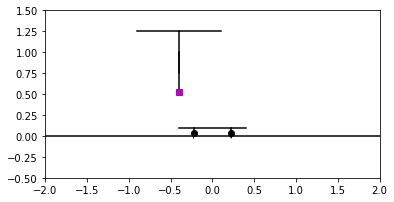

In [123]:
#animate it
import matplotlib.pyplot as plt
import matplotlib.animation as ani
from IPython.display import HTML
%matplotlib inline

fig1, ax1 = plt.subplots(1,1) #create axes
ax1.set_aspect('equal')

def plot_board(i,m,ax): #update function for animation
    XMIN = -2.0
    XMAX = 2.0
    YMIN = -0.5
    YMAX = 1.5
    MARKER_SIZE = 6
    
    ax.clear()
    ax.set_xlim([XMIN,XMAX])
    ax.set_ylim([YMIN,YMAX])

    #plot ground
    groundLx = XMIN
    groundLy = 0
    groundRx = XMAX
    groundRy = 0
    ax.plot([groundLx,groundRx],[groundLy,groundRy],color='xkcd:black')
    
    #plot skateboard
    boardLx = m.ptail[i,'x'].value
    boardLy = m.ptail[i,'y'].value
    boardRx = m.pnose[i,'x'].value
    boardRy = m.pnose[i,'y'].value
    ax.plot([boardLx,boardRx],[boardLy,boardRy],color='xkcd:black')
    
    #plot left wheel
    leftwheelTopx = m.q[i,'x'].value-0.5*m.lbrd*np.cos(m.q[i,'th'].value)
    leftwheelTopy = m.q[i,'y'].value-0.5*m.lbrd*np.sin(m.q[i,'th'].value)
    leftwheelBottomx = m.pbackwheel[i,'x'].value
    leftwheelBottomy = m.pbackwheel[i,'y'].value
    ax.plot([leftwheelTopx,leftwheelBottomx],[leftwheelTopy,leftwheelBottomy],color='xkcd:black')
    
    #plot left wheel-wheel
    leftwheelx = m.q[i,'x'].value-0.5*m.lbrd*cos(m.q[i,'th'].value)+0.6*m.hbd*sin(m.q[i,'th'].value)
    leftwheely = m.q[i,'y'].value-0.5*m.lbrd*sin(m.q[i,'th'].value)-0.6*m.hbd*cos(m.q[i,'th'].value)
    ax.plot(leftwheelx,leftwheely,color='xkcd:black',marker = 'o',markersize=MARKER_SIZE)
    
    #plot right wheel
    rightwheelTopx = m.q[i,'x'].value+0.5*m.lbrd*np.cos(m.q[i,'th'].value)
    rightwheelTopy = m.q[i,'y'].value+0.5*m.lbrd*np.sin(m.q[i,'th'].value)
    rightwheelBottomx = m.pfrontwheel[i,'x'].value
    rightwheelBottomy = m.pfrontwheel[i,'y'].value
    ax.plot([rightwheelTopx,rightwheelBottomx],[rightwheelTopy,rightwheelBottomy],color='xkcd:black')
    
    #plot right wheel-wheel
    rightwheelx = m.q[i,'x'].value+0.5*m.lbrd*cos(m.q[i,'th'].value)+0.6*m.hbd*sin(m.q[i,'th'].value)
    rightwheely = m.q[i,'y'].value+0.5*m.lbrd*sin(m.q[i,'th'].value)-0.6*m.hbd*cos(m.q[i,'th'].value)
    ax.plot(rightwheelx,rightwheely,color='xkcd:black',marker = 'o',markersize=MARKER_SIZE)
    
    #plot forces
    backforcex = m.q[i,'x'].value - m.rF[i,'BF'].value*cos(m.q[i,'th'].value)
    backforcey = m.q[i,'y'].value - m.rF[i,'BF'].value*sin(m.q[i,'th'].value)
    frontforcex = m.q[i,'x'].value + m.rF[i,'FF'].value*cos(m.q[i,'th'].value)
    frontforcey = m.q[i,'y'].value + m.rF[i,'FF'].value*sin(m.q[i,'th'].value)
    
    if maxForce!=0:
        magforceBFy = m.F[i,'BFy'].value/maxForce
        magforceFFy = m.F[i,'FFy'].value/maxForce 
        magforceBFx = m.F[i,'BFx'].value/maxForce
        magforceFFx = m.F[i,'FFx'].value/maxForce 
        
        ax.arrow(backforcex, backforcey+magforceBFy*0.5,0,-magforceBFy*0.5, length_includes_head=True,head_width=magforceBFy*0.05,color='red')
        ax.arrow(frontforcex, frontforcey+magforceFFy*0.5,0,-magforceFFy*0.5, length_includes_head=True,head_width=magforceFFy*0.05,color='red')

        ax.arrow(backforcex-magforceBFx*0.5, backforcey,magforceBFx*0.5,0, length_includes_head=True,head_width=magforceBFy*0.05,color='red')
        ax.arrow(frontforcex-magforceFFx*0.5,frontforcey,magforceFFx*0.5,0, length_includes_head=True,head_width=magforceFFy*0.05,color='red')
    
    #plot GRF's
    if (m.GRF[i,'BW'].value is not None) and (m.GRF[i,'BW'].value!=0.0):
        magGRFBW = m.GRF[i,'BW'].value/maxGRF
    else: 
        magGRFBW = 0
    if (m.GRF[i,'FW'].value is not None) and (m.GRF[i,'FW'].value!=0.0):
        magGRFFW = m.GRF[i,'FW'].value/maxGRF
    else: 
        magGRFFW = 0
        
    backGRFx = leftwheelBottomx
    backGRFy = leftwheelBottomy
    frontGRFx = rightwheelBottomx
    frontGRFy = rightwheelBottomy        

    ax.arrow(backGRFx, backGRFy-magGRFBW*0.5,0,magGRFBW*0.5, length_includes_head=True,head_width=magGRFBW*0.05,color='blue')
    ax.arrow(frontGRFx, frontGRFy-magGRFFW*0.5,0,magGRFFW*0.5, length_includes_head=True,head_width=magGRFFW*0.05,color='blue')
    
    #plot monopod
    #plot body
    body_xb = m.q[i,'xb'].value - 0.5*m.len[('body',1)]*cos(m.q[i,'thb'].value)
    body_yb = m.q[i,'yb'].value - 0.5*m.len[('body',1)]*sin(m.q[i,'thb'].value)
    body_xf = m.q[i,'xb'].value + 0.5*m.len[('body',1)]*cos(m.q[i,'thb'].value)
    body_yf = m.q[i,'yb'].value + 0.5*m.len[('body',1)]*sin(m.q[i,'thb'].value)  
    ax.plot([body_xb,body_xf],[body_yb,body_yf],color='k')
      
    #plot leg 1
    thA = m.q[i,'thb'].value+m.q[i,'thl'].value
    leg1_xt = m.q[i,'xb'].value
    leg1_yt = m.q[i,'yb'].value
    leg1_xb = m.q[i,'xb'].value + m.len[('leg',1)]*sin(thA)
    leg1_yb = m.q[i,'yb'].value - m.len[('leg',1)]*cos(thA)
    ax.plot([leg1_xt,leg1_xb],[leg1_yt,leg1_yb],color='k')
    
    #plot leg 2
    Lt = 0.5*m.len[('leg',1)] + m.q[i,'r'].value - 0.5*m.len[('leg',2)]
    Lb = 0.5*m.len[('leg',1)] + m.q[i,'r'].value + 0.5*m.len[('leg',2)]
    leg2_xt = m.q[i,'xb'].value + Lt*sin(thA)
    leg2_yt = m.q[i,'yb'].value - Lt*cos(thA)
    leg2_xb = m.q[i,'xb'].value + Lb*sin(thA)
    leg2_yb = m.q[i,'yb'].value - Lb*cos(thA)
    ax.plot([leg2_xt,leg2_xb],[leg2_yt,leg2_yb],color='k')
    ax.plot(leg2_xb,leg2_yb+0.03,color='m',marker = 's')
    
    if maxForce!=0:
        ax.arrow(leg2_xb, leg2_yb-magforceBFy*0.5,0,magforceBFy*0.5, length_includes_head=True,head_width=magforceBFy*0.05,color='y')
    
update = lambda i: plot_board(i,m,ax1) #lambdify update function

animate = ani.FuncAnimation(fig1, update, frames=range(1,N+1), interval=100, repeat=True)

HTML(animate.to_html5_video()) #you need to convert the animation to HTML5 to embed it in the notebook


In [124]:
# from IPython.display import display #for pretty printing
# #display(sym.solve(EOMs_monopod, [ddq[0]]))
# display(sym.solve(EOMs_monopod[0], [ddq[0]]))

In [125]:
#print(maxForce)

In [126]:
#m.F_r.pprint()